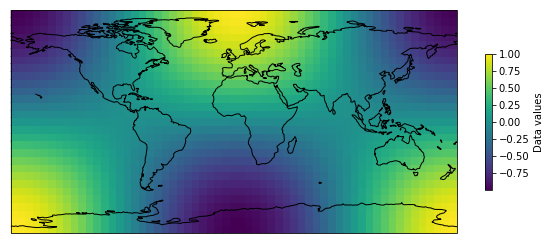

In [61]:
import iris
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs
import xarray as xr
warnings.filterwarnings("ignore")

In [30]:
# this is the crs that we want to transform from
source_crs_1km = ccrs.OSGB(approx=False)
# these are the crs we are transforming to
target_crs = ccrs.Geodetic()

### Get one months data in the original format (fresh download)

In [392]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat_v2/")
for filename in glob.glob("*"):
    print(filename)
    cube = iris.load(filename)[0]

CEH-GEAR-1hr-v2_199001.nc


### Reformat so it doesnt have missing attributes

In [94]:
def make_bng_cube_keep_attributes(filename,variable):
    xr_ds=xr.open_dataset(filename)
    # Store the northings values
    raw_northings=xr_ds['y'].values
    # Store the eastings values
    raw_eastings=xr_ds['x'].values
    # Find the length of northings and eastings 
    lrn=len(raw_northings)
    lre=len(raw_eastings)
    # Set up a OS_GB (BNG) coordinate system
    os_gb=TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))
    
    # Create northings and eastings dimension coordinates
    northings = DimCoord(raw_northings, standard_name=u'projection_y_coordinate', 
                         units=Unit('m'), var_name='projection_y_coordinate', coord_system=os_gb)
    eastings = DimCoord(raw_eastings, standard_name=u'projection_x_coordinate', 
                        units=Unit('m'), var_name='projection_x_coordinate', coord_system=os_gb)
    
    northings.guess_bounds()
    eastings.guess_bounds()
    
    # Create a time dimension coordinate
    iris_time=(xr_ds['time'].values-np.datetime64("1970-01-01T00:00")) / np.timedelta64(1, "s")
    iris_time=DimCoord(iris_time, standard_name='time',units=cf_units.Unit('seconds since 1970-01-01', calendar='gregorian'))
    
    ### Apply these new coordinates on a copy of the old cube
    cube_new = cube.copy()
    # cube_new.remove_coord(x_coord_name)
    # cube_new.remove_coord(y_coord_name)
    # If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
    cube_new.add_dim_coord(northings, 1)  # Assuming latitude corresponds to the first dimension
    cube_new.add_dim_coord(eastings, 2)  # And longitude to the second
    # cube_new.add_dim_coord(iris_time, 1)
    da=xr_ds[variable]
    cube_new.data = np.float32(da.values)

    return cube_new

In [357]:
cube_rf = make_bng_cube_keep_attributes(filename, 'rainfall_amount')

In [107]:
### Why are first timeslices blank?

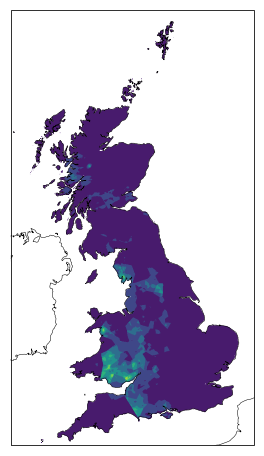

In [106]:
fig, ax= plt.subplots(figsize=(10,8))
iplt.contourf(cube_rf[15,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [283]:
def convert_to_wgs84(source_crs, target_crs, cube, x_coord_name, y_coord_name):
    # Extract the 2D meshgrid of X (eastings) and Y (northings) coordinates from the cube
    x = cube.coord(x_coord_name).points
    y = cube.coord(y_coord_name).points
    xx, yy = np.meshgrid(x, y)

    # Also get time for the new cube
    time_coord = cube.coord('time')

    # Use transform_points to project your coordinates
    transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

    # transformed_points now has a shape (n*m, 3), where the last dimension contains (lon, lat, z)
    # Reshape the array back to your original grid shape and separate the components
    lons, lats = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

    # Now, you should create a new cube with these lons and lats as coordinates.
    # Note: This step requires careful handling to ensure the new cube's data aligns correctly with the transformed coordinates.
    # You might need to create new latitude and longitude DimCoords, ensuring they have bounds set if performing area-weighted regridding later.

    # Here's a simplified way to create a new cube with the transformed coordinates,
    # assuming your original data is 2-dimensional and compatible with the new grid.
    new_cube_data = cube.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
    latitude_coord = iris.coords.DimCoord(lats[:, 0], standard_name='latitude', units='degrees')
    longitude_coord = iris.coords.DimCoord(lons[0, :], standard_name='longitude', units='degrees')

    # Guess bounds
    latitude_coord.guess_bounds()
    longitude_coord.guess_bounds()

    cube_wgs84 = cube.copy()
    cube_wgs84.remove_coord(x_coord_name)
    cube_wgs84.remove_coord(y_coord_name)
    # If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
    cube_wgs84.add_dim_coord(latitude_coord, 1)  # Assuming latitude corresponds to the first dimension
    cube_wgs84.add_dim_coord(longitude_coord, 2)  # And longitude to the second
    
    return cube_wgs84

### Convert to WGS84

In [318]:
# What the data is in currently
source_crs = transverse_mercator_crs = ccrs.TransverseMercator(
    central_longitude=-2.0,
    central_latitude=49.0,
    false_easting=400000,
    false_northing=-100000,
    scale_factor=0.9996012717,
    globe=ccrs.Globe(semimajor_axis=6377563.396, semiminor_axis=6356256.909))

# what we want the data to be in
target_crs = ccrs.Geodetic()

transformed_cube_12km = convert_to_wgs84 (source_crs, target_crs, cube_rf,
                                          'projection_x_coordinate', 'projection_y_coordinate')

### Set the cube's coordinate system

In [290]:
import iris.coord_systems

# Define a geographic coordinate system based on the WGS84 ellipsoid
wgs84 =  iris.coord_systems.GeogCS(semi_major_axis=6378137, inverse_flattening=298.257223563)
for coord in transformed_cube_12km.coords():
    if coord.standard_name in ['latitude', 'longitude'] or coord.long_name in ['latitude', 'longitude']:
        coord.coord_system = wgs84

### Try manual plotting (and conversion)

In [371]:
# Get x and y coordinates
proj_x = cube_rf.coord("projection_x_coordinate").points
proj_y = cube_rf.coord("projection_y_coordinate").points
# Convert to 2D
xx, yy = np.meshgrid(proj_x, proj_y)

# Get the pre-existing coordinate system
cs_start = cube_rf.coord_system()
# convert to cartopy projection
cs_start_cart = cs_start.as_cartopy_projection()

# Get the desired coordinate system
# cs_end = iris.coord_systems.GeogCS(iris.analysis.cartography.DEFAULT_SPHERICAL_EARTH_RADIUS)
# WGS84
cs_end = iris.coord_systems.GeogCS(semi_major_axis=6378137, inverse_flattening=298.257223563)
# Again, convert it to a cartopy projection
cs_end_cart = cs_end.as_cartopy_projection()

# Transform the lons and lats into the desired projection
lons, lats, _ = cs_end_cart.transform_points(cs_start_cart, xx.flatten(), yy.flatten()).T

# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.pcolormesh(proj_x, proj_y, cube_rf.data[15,:,:], transform=cs_start_cart)
# ax.coastlines()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.pcolormesh(proj_x, proj_y, cube_rf.data[15,:,:], transform=cs_start_cart)
ax.coastlines()

In [391]:
lons, lats, _ = cs_end_cart.transform_points(cs_start_cart, xx.flatten(), yy.flatten()).T
# lons = lons.reshape(xx.shape)
# lats = lats.reshape(yy.shape)
# lons.shape
np.unique(lons, return_counts=True)

(array([-9.39096719, -9.38889341, -9.38682097, ...,  3.55198555,
         3.55355077,  3.555117  ]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
cube_rf = make_bng_cube_keep_attributes(filename, 'rainfall_amount')

In [372]:
lons.shape

(876951,)

In [368]:
lats.shape

(1251, 701)

In [387]:
np.unique(x, return_counts=True)
x.shape

(701,)

In [389]:
np.unique(lats, return_counts=True)
lats.shape

(1251, 701)

In [404]:
# Extract the 2D meshgrid of X (eastings) and Y (northings) coordinates from the cube
x = cube_rf.coord('projection_x_coordinate').points # long
y = cube_rf.coord('projection_y_coordinate').points # lat
# Convert to 2D
xx, yy = np.meshgrid(x, y)

# Also get time for the new cube
time_coord = cube_rf.coord('time')

# Use transform_points to project your coordinates
transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

# transformed_points now has a shape (n*m, 3), where the last dimension contains (lon, lat, z)
# Reshape the array back to your original grid shape and separate the components
lons, lats = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

# Now, you should create a new cube with these lons and lats as coordinates.
# Note: This step requires careful handling to ensure the new cube's data aligns correctly with the transformed coordinates.
# You might need to create new latitude and longitude DimCoords, ensuring they have bounds set if performing area-weighted regridding later.

# Here's a simplified way to create a new cube with the transformed coordinates,
# assuming your original data is 2-dimensional and compatible with the new grid.
new_cube_data = cube_rf.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
latitude_coord = iris.coords.DimCoord(lats[:, 0], standard_name='latitude', units='degrees')
longitude_coord = iris.coords.DimCoord(lons[0, :], standard_name='longitude', units='degrees')

# Guess bounds
latitude_coord.guess_bounds()
longitude_coord.guess_bounds()

cube_wgs84 = cube_rf.copy()
cube_wgs84.remove_coord('projection_x_coordinate')
cube_wgs84.remove_coord('projection_y_coordinate')
# If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
cube_wgs84.add_dim_coord(latitude_coord, 1)  # Assuming latitude corresponds to the first dimension
cube_wgs84.add_dim_coord(longitude_coord, 2)  # And longitude to the second

In [452]:
bng_crs = ccrs.OSGB()

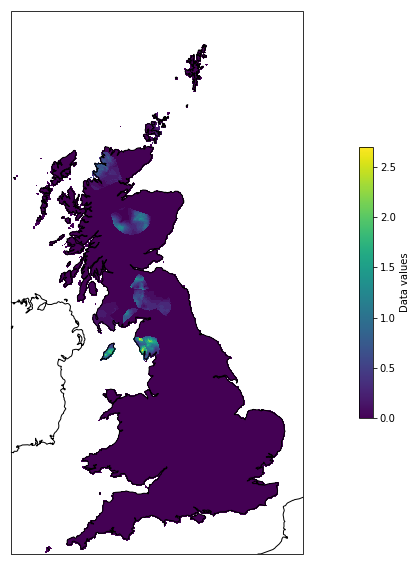

In [453]:
# Create a figure and axis with a geographic projection (PlateCarree is common for WGS84 data)
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.OSGB()})
# ax.set_global()  # Optional: Sets the extent of the map to the global extent
ax.set_extent([0, 800000, 0, 1300000], crs=bng_crs)
# [-13, 3, 49, 61]
# Add coastlines for context
ax.coastlines()

# Plot the data using pcolormesh, specifying the projection of the data ('transform' argument)
mesh = ax.pcolormesh(x, y, new_cube_data[100,:,:], transform=ccrs.OSGB(), shading='auto')

# Add a colorbar
plt.colorbar(mesh, ax=ax, shrink=0.5, label='Data values')

# Optional: Set the map's extent (if you want to zoom in on a specific area)
# ax.set_extent([lon_min, lon_max, lat_min, lat_max])

plt.show()

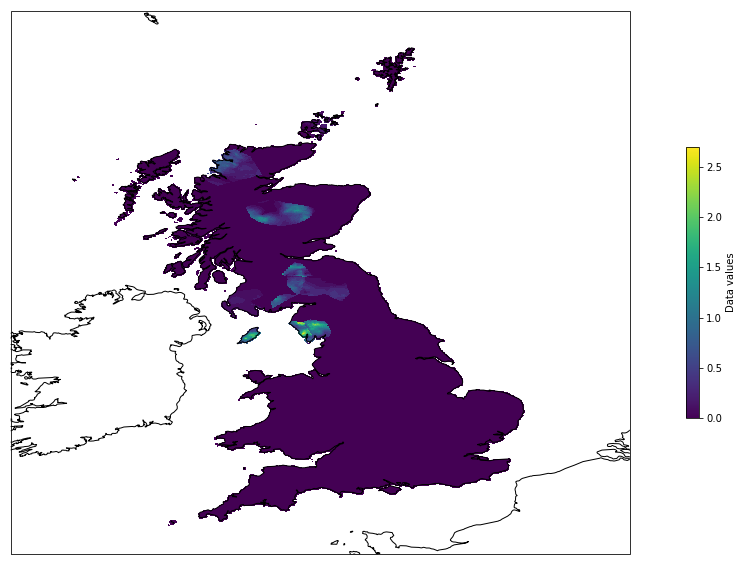

In [409]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming 'lats' and 'lons' are 2D arrays of latitude and longitude values in WGS84
# And 'data' is the 2D array of data values corresponding to these lat/lon points
# For example purposes, let's create some sample data:
# lons, lats = np.meshgrid(np.linspace(-180, 180, 60), np.linspace(-90, 90, 30))
# data = np.sin(np.deg2rad(lats)) * np.cos(np.deg2rad(lons))

# Create a figure and axis with a geographic projection (PlateCarree is common for WGS84 data)
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_global()  # Optional: Sets the extent of the map to the global extent

# Add coastlines for context
ax.coastlines()

# Plot the data using pcolormesh, specifying the projection of the data ('transform' argument)
mesh = ax.pcolormesh(lons, lats, new_cube_data[100,:,:], shading='auto')

# Add a colorbar
plt.colorbar(mesh, ax=ax, shrink=0.5, label='Data values')

# Optional: Set the map's extent (if you want to zoom in on a specific area)
# ax.set_extent([lon_min, lon_max, lat_min, lat_max])

plt.show()


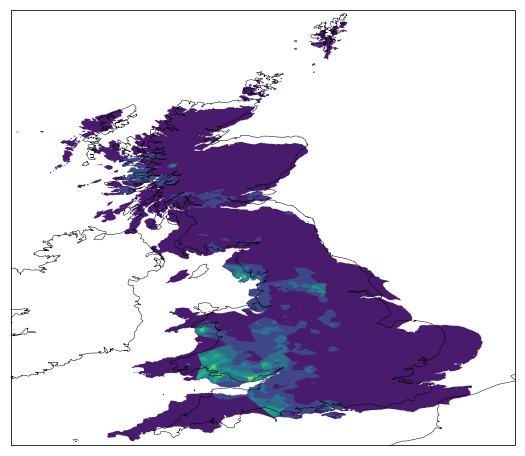

In [380]:
fig, ax= plt.subplots(figsize=(10,8))
iplt.contourf(cube_wgs84[15,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5)

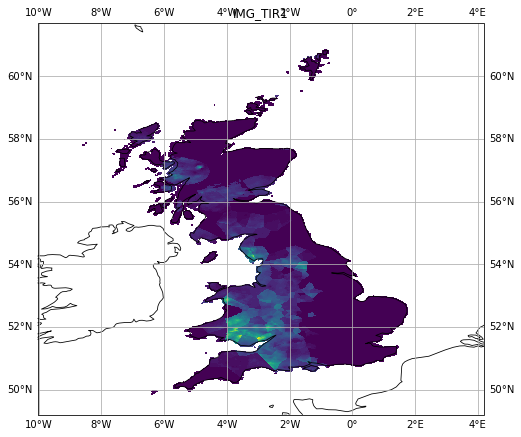

In [308]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Y = cube_rf.coord("projection_y_coordinate").points
X = cube_rf.coord("projection_x_coordinate").points
IMG_TIR1 = cube_rf[1,:,:].data

globe = ccrs.Globe(semimajor_axis=6378137, semiminor_axis=6356752.3142)
proj = ccrs.Mercator(central_longitude=77.25,
                     latitude_true_scale=17.75, globe=globe)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.pcolormesh(proj_x, proj_y, cube_rf.data[15,:,:], transform=cs_start_cart)
# ax.pcolormesh(X, Y, IMG_TIR1, cmap=plt.cm.gist_gray)
ax.coastlines('50m', linewidth=0.8, color='black')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
plt.title('IMG_TIR1')

plt.show()


# p = pyproj.Proj("+proj=merc +lon_0=77.25 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356752.3142 +lat_ts=17.75 "
#                     "+ellps=WGS84 +datum=WGS84 +towgs84=0,0,0 +units=m +no_defs")
# xv, yv = np.meshgrid(X, Y)
# lon_grid, lat_grid = p(xv, yv, inverse=True)

### Method that works, but not sure how to apply the coordinates back on the cube


In [205]:
import iris.coords
# Assuming lons and lats are 2D arrays representing the longitude and latitude positions
# Reshape them back to 2D arrays from the flattened version
lons_2d = lons.reshape(xx.shape)
lats_2d = lats.reshape(yy.shape)

# Create new AuxCoord objects for the reprojected longitude and latitude
new_lon_coord = iris.coords.AuxCoord(lons_2d,
                                     standard_name='longitude',
                                     units='degrees',
                                     coord_system=cs_tgt)
new_lat_coord = iris.coords.AuxCoord(lats_2d,
                                     standard_name='latitude',
                                     units='degrees',
                                     coord_system=cs_tgt)



# Remove old 'projection_x_coordinate' and 'projection_y_coordinate' coordinates
# cube_rf.remove_coord('projection_x_coordinate')
# cube_rf.remove_coord('projection_y_coordinate')

# Add new longitude and latitude coordinates to the cube
cube_rf.add_aux_coord(new_lon_coord, data_dims=(1, 2))
cube_rf.add_aux_coord(new_lat_coord, data_dims=(1, 2))


In [ ]:
x

### Test process on one cube

In [56]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted")
cube = iris.load(filename)[0]
# transform to wgs84
transformed_cube_12km = convert_to_wgs84 (transverse_mercator_crs, target_crs, cube,
                                          'projection_x_coordinate', 'projection_y_coordinate')
# Save 
# iris.save(transformed_cube_12km, output_fp +  f"wgs84_{filename}")

In [33]:
# Check preexsting coordinate system
cube.coord('projection_y_coordinate')

transverse_mercator_crs = ccrs.TransverseMercator(
    central_longitude=-2.0,
    central_latitude=49.0,
    false_easting=400000,
    false_northing=-100000,
    scale_factor=0.9996012717,
    globe=ccrs.Globe(semimajor_axis=6377563.396, semiminor_axis=6356256.909)
)

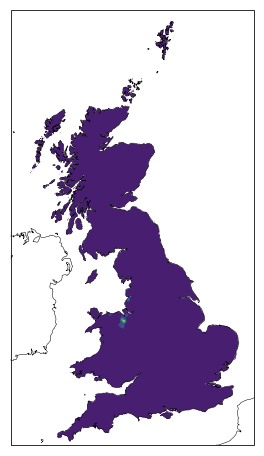

In [35]:
fig, ax= plt.subplots(figsize=(10,8))
iplt.contourf(cube[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

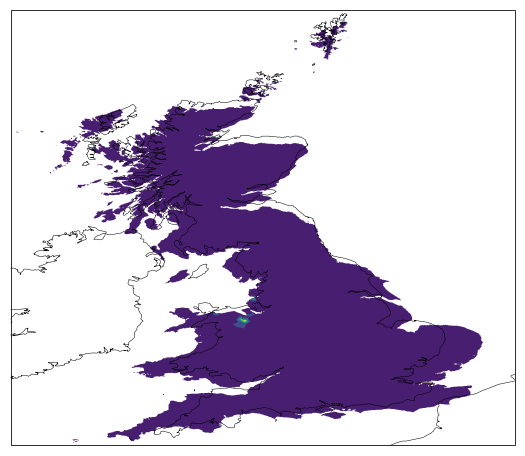

In [50]:
fig, ax= plt.subplots(figsize=(15,8))
iplt.contourf(transformed_cube_12km[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Run process on all cubes

In [ ]:
output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/AreaWeighted/"
if not os.path.isdir(output_fp):
    os.makedirs(output_fp)

os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted")
for filename in glob.glob("*")
    if not os.path.isfile(output_fp +  f"wgs84_{filename}"):
        print("already exist")
    else:
        print(filename)
        cube = iris.load(filename)[0]
        # transform to wgs84
        transformed_cube_12km = convert_to_wgs84 (source_crs_12km, target_crs, cube,'projection_x_coordinate', 'projection_y_coordinate')
        # Save 
        iris.save(transformed_cube_12km, output_fp +  f"wgs84_{filename}") 



In [6]:
# ##################################################################
# # This is a square area surrounding Leeds
# leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
# cube_12km_trimmed_to_leeds =  trim_to_bbox_of_region_obs(cube_12km, leeds_at_centre_gdf, 'projection_y_coordinate',
#                                                         'projection_x_coordinate')